## Looping detector

In [1]:
from reader import Reader
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from datetime import datetime
from datetime import date as date_creator
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from numba import njit
import pandas as pd
import os
from numba import jit

%matplotlib inline

C:\Users\barroisl\AppData\Local\Temp\ipykernel_11072\3735118499.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def smooth(x,window_len=11,window='hanning'):
        if x.ndim != 1:
                raise ValueError("smooth only accepts 1 dimension arrays.")
        if x.size < window_len:
                raise ValueError("Input vector needs to be bigger than window size.")
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]
def get_date_time_dif(start_time,stop_time):
    date = date_creator(1, 1, 1)
    datetime1 = datetime.combine(date, start_time)
    datetime2 = datetime.combine(date, stop_time)
    time_elapsed = datetime1 - datetime2
    return time_elapsed.total_seconds()
def compute_dist(lat1,lon1,lat2,lon2,rad=True):
    if not(rad):
        lat1 = radians(lat1)
        lon1 = radians(lon1)
        lat2 = radians(lat2)
        lon2 = radians(lon2)
    # approximate radius of earth in m
    R = 6373_000.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c
def remove_zero_from_alti(alti):
    if alti[0] < 10 :
        alti[0] = alti[1]
    if alti[-1] < 10 :
        alti[-1] = alti[-2]
    for i,alt in enumerate(alti):
        if alt < 10 :
            if i >= len(alti)-1 :
                alti[i] = (alti[i-1]+alti[i])/2
            else :  
                alti[i] = (alti[i-1]+alti[i+1])/2
    return alti

def read_igc(file):
    with open(file, 'r') as f:
        parsed_igc_file = Reader().read(f)
    # print('igc_file created')
    previous_lat = 0
    previous_lon = 0
    
    all_lon = np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_lat = np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_speed=np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_vz=np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_alti=np.zeros(len(parsed_igc_file['fix_records'][1]))
    all_time=[0 for _ in range(len(parsed_igc_file['fix_records'][1]))]

    for i,record in enumerate(parsed_igc_file['fix_records'][1]):
        record['time'] = record['time'].replace(hour=record['time'].hour + 1)
        all_lat[i] = record['lat']
        all_lon[i] = record['lon']
        if previous_lon ==0 :
            previous_lat = record['lat']
            previous_lon = record['lon']
            previous_datetime = record['time']
            previous_alt_gps = record['gps_alt']
            # previous_alt_baro = record['pressure_alt']
            all_time[i] = record['time']
        else :
            dxy = abs(compute_dist(previous_lat,previous_lon,record['lat'],record['lon'],rad=False))
            # dz = previous_alt_baro-record['pressure_alt']
            dz = previous_alt_gps-record['gps_alt']
            dt = get_date_time_dif(record['time'],previous_datetime)
            # if dt>2 : print('dtttttt>2 ',dt)
            if dt>0 :
                all_speed[i] = min(100,dxy/dt*3.6)
                all_vz[i] = dz/dt
            all_alti[i] = record['gps_alt']
            all_time[i] = record['time']
            
            previous_lat = record['lat']
            previous_lon = record['lon']
            previous_datetime = record['time']
            previous_alt_gps = record['gps_alt']
            # previous_alt_baro = record['pressure_alt']

            # if previous_datetime.hour>10 :
            #     all_speed = all_speed[:i]
            #     all_vz = all_vz[:i]
            #     all_alti = all_alti[:i]
            #     break
#    return all_lon,all_lat,all_speed,all_vz,remove_zero_from_alti(all_alti),all_time
    return all_lon,all_lat,all_alti,all_time

def reshape_array(arr,time_vid):
    nb_img_by_sec = 24
    
    t_true = np.linspace(time_vid[0], time_vid[-1], num=len(time_vid), endpoint=True)
    t_inter = np.linspace(time_vid[0], time_vid[-1], num=int(len(time_vid)*nb_img_by_sec/speed_acc), endpoint=True)
    f = interp1d(t_true, arr, kind='cubic')

    return f(t_inter)

def smooth_igc_output(L_all):
    all_ret = []
    for l_val in L_all:
        l_val[0]=l_val[1]#=np.mean(l_val[:int(len(l_val)/10)])
        smoothed = smooth(l_val,50,'hanning')
        all_ret.append(smoothed)
    return all_ret

def plot_smooth_non_smooth(smooth,non_smooth):
    plt.figure(figsize=(18,9))
    plt.plot(non_smooth)
    plt.plot(smooth)
    plt.show()

def get_last_date_of_all_raw_file(path_raw_file):
    delta_time_writing = 20
    all_ending_time = []
    for file in os.listdir(path_raw_file):
        if "_11_" in file :
            time_end = os.path.getmtime(path_raw_file+'\\'+file)
            all_ending_time.append(datetime.fromtimestamp(time_end-delta_time_writing).time())
    return all_ending_time

def convert_time_to_sec(all_time):
    for i in range(len(all_time)):
        all_time[i] = all_time[i].hour*3600 + all_time[i].minute*60 + all_time[i].second
    return np.array(all_time,dtype=np.float32)

In [3]:
from os import listdir
from os.path import isfile, join
path = 'C:/Users/barroisl/Documents/Stage_Léo/Vols/IGC_20-08-2023/Parapente_old/'
#path = 'IGC_20-08-2023/'
#list_files = [path+f for f in listdir(path) if isfile(join(path, f))]
list_files = [f for f in listdir(path) if isfile(join(path, f))]

print(len(list_files))

72


In [6]:
file = '2023-08-20-XCT-BLA-01.igc'
path = 'C:/Users/barroisl/Documents/Stage_Léo/Vols/IGC_20-08-2023/Parapente_old/'
#all_lon,all_lat,speed_vid,vz_vid,alti_vid,time_vid,all_vz2,all_speed_smooth, all_vz_smooth, all_alti_smooth,all_alti = prep_file(path, file)
all_lon,all_lat,all_alti,all_time = read_igc(join(path,file))

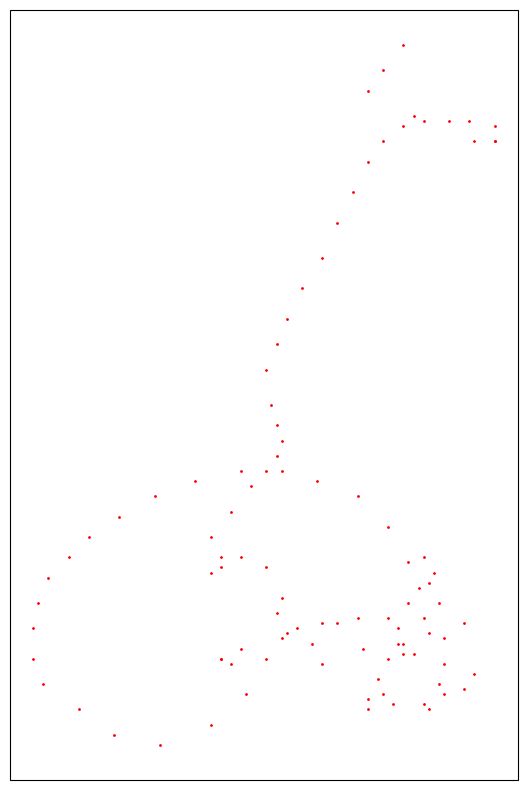

In [29]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree())
img_extent = (4.7942, 8.1545, 43.3545, 46.6707)
#img_extent = (-5.5, 8, 42, 51.5)

fname = 'C:/Users/barroisl/Documents/Stage_Léo/Satellites/Images_MODIS_VIIRS/Alp_2023-08-20_12H28.jpg'
#fname = 'T:/C2H/STAGES/LEO_BARROIS/PIA03393.tif'

#mg = plt.imread(fname)

#ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())
ax.scatter(all_lon[150:250],all_lat[150:250],s=1,color = 'r')
plt.show()

In [14]:
n = len(all_lat)
theta = np.zeros((1,n-1))
for j in range(n-1):
        theta[0,j] = np.arctan((all_lat[j+1]-all_lat[j])/(all_lon[j+1]-all_lon[j]))

C:\Users\barroisl\AppData\Local\Temp\ipykernel_11072\2561646321.py:4: RuntimeWarning: invalid value encountered in scalar divide
  theta[0,j] = np.arctan((all_lat[j+1]-all_lat[j])/(all_lon[j+1]-all_lon[j]))
C:\Users\barroisl\AppData\Local\Temp\ipykernel_11072\2561646321.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  theta[0,j] = np.arctan((all_lat[j+1]-all_lat[j])/(all_lon[j+1]-all_lon[j]))


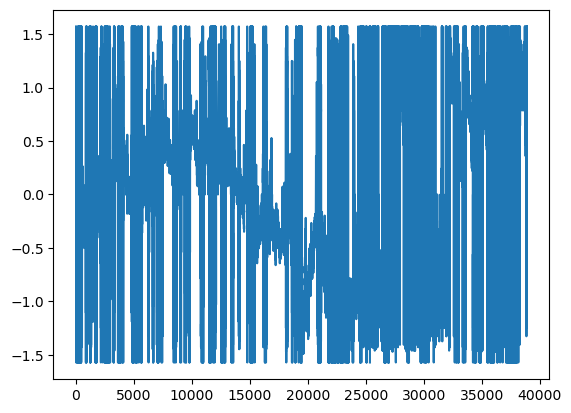

In [39]:
plt.plot(theta[0])

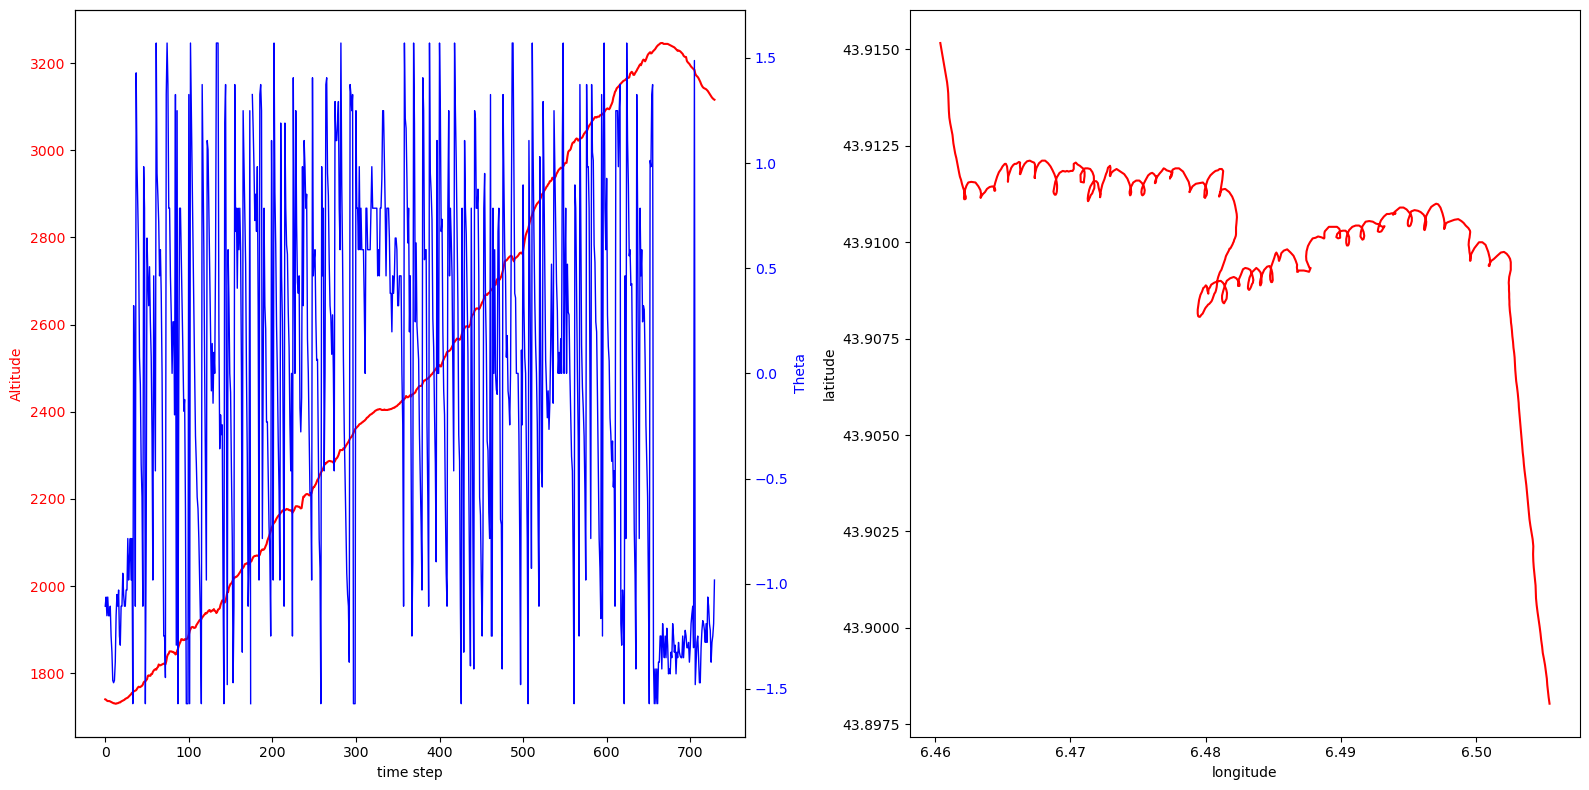

In [196]:
ext = [22770,23500]

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(16, 8))

ax1.set_xlabel('time step') 
ax1.set_ylabel('Altitude', color = 'red') 
ax1.plot(all_alti[ext[0]:ext[1]],'r') 
ax1.tick_params(axis ='y', labelcolor = 'red') 

# Create a twin axis sharing the x-axis with ax1
ax2 = ax1.twinx() 
ax2.set_ylabel('Theta', color = 'blue') 
ax2.plot(theta[0,ext[0]:ext[1]],'b',linewidth = 1)
ax2.tick_params(axis ='y', labelcolor = 'blue') 

# Plot on the second subplot
ax3.plot(all_lon[ext[0]:ext[1]], all_lat[ext[0]:ext[1]], 'r-')
ax3.set_xlabel('longitude')
ax3.set_ylabel('latitude')
plt.tight_layout()

plt.show()


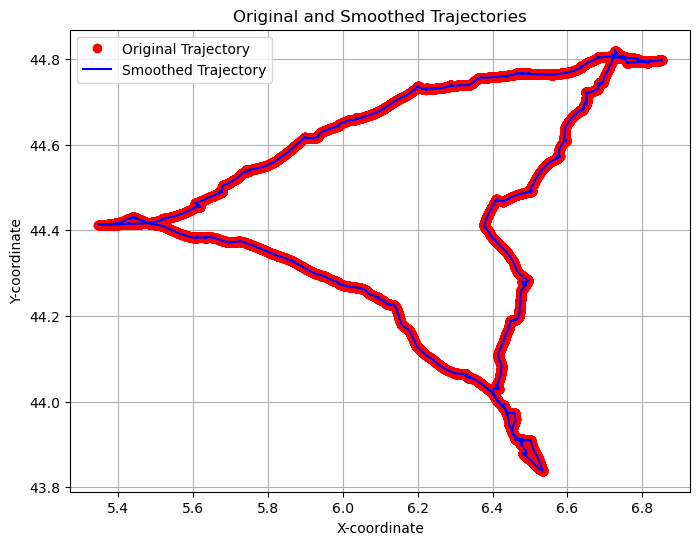

In [358]:
from scipy.interpolate import CubicSpline
n = len(all_lat)
ext = [0,n]
length = ext[1]-ext[0]
t = np.linspace(0, length, length)  # Time points
spline_lon = CubicSpline(t, all_lon[ext[0]:ext[1]])
spline_lat = CubicSpline(t, all_lat[ext[0]:ext[1]])

# Define finer time points for interpolation
t_interp = np.linspace(0, length, length*100)

# Interpolate smoothed trajectories
lon_interp = spline_lon(t_interp)
lat_interp = spline_lat(t_interp)

# Plot original and smoothed trajectories
plt.figure(figsize=(8, 6))
plt.plot(all_lon[ext[0]:ext[1]], all_lat[ext[0]:ext[1]], 'ro', label='Original Trajectory')
plt.plot(lon_interp, lat_interp, 'b-', label='Smoothed Trajectory')
plt.title('Original and Smoothed Trajectories')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.grid(True)
plt.show()


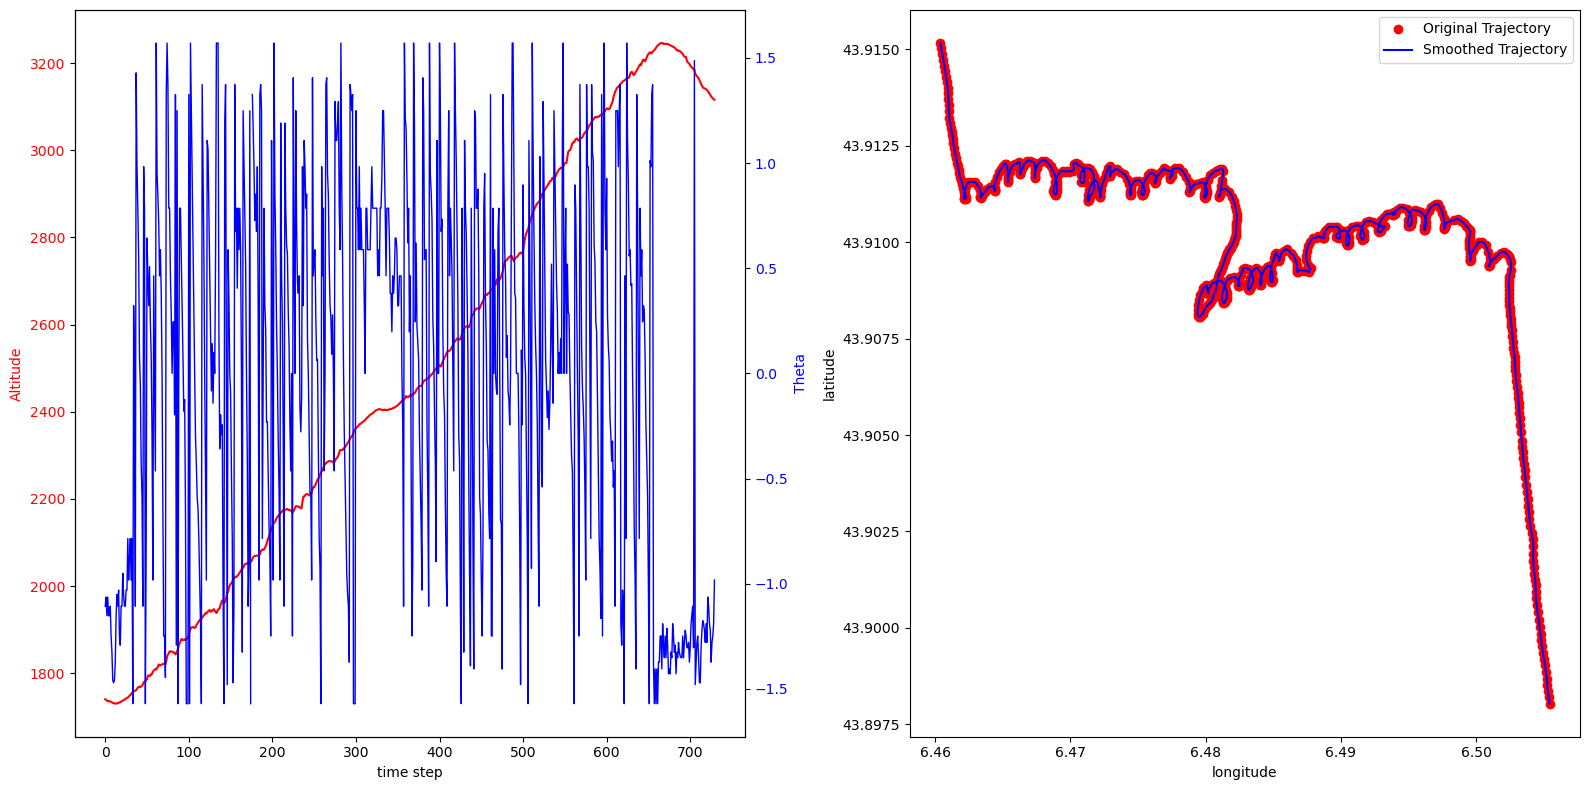

In [344]:
ext = [22770,23500]

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(16, 8))

ax1.set_xlabel('time step') 
ax1.set_ylabel('Altitude', color = 'red') 
ax1.plot(all_alti[ext[0]:ext[1]],'r') 
ax1.tick_params(axis ='y', labelcolor = 'red') 

# Create a twin axis sharing the x-axis with ax1
ax2 = ax1.twinx() 
ax2.set_ylabel('Theta', color = 'blue') 
ax2.plot(theta[0,ext[0]:ext[1]],'b',linewidth = 1)
ax2.tick_params(axis ='y', labelcolor = 'blue') 

# Plot on the second subplot
ax3.plot(all_lon[ext[0]:ext[1]], all_lat[ext[0]:ext[1]], 'ro', label='Original Trajectory')
ax3.plot(lon_interp, lat_interp, 'b-', label='Smoothed Trajectory')
ax3.set_xlabel('longitude')
ax3.set_ylabel('latitude')
ax3.legend()
plt.tight_layout()

plt.show()

In [359]:
n = len(lat_interp)
theta_interp = np.zeros((1,n-1))
for j in range(n-1):
        theta_interp[0,j] = np.arctan((lat_interp[j+1]-lat_interp[j])/(lon_interp[j+1]-lon_interp[j]))

C:\Users\barroisl\AppData\Local\Temp\ipykernel_11072\2718515642.py:4: RuntimeWarning: invalid value encountered in scalar divide
  theta_interp[0,j] = np.arctan((lat_interp[j+1]-lat_interp[j])/(lon_interp[j+1]-lon_interp[j]))
C:\Users\barroisl\AppData\Local\Temp\ipykernel_11072\2718515642.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  theta_interp[0,j] = np.arctan((lat_interp[j+1]-lat_interp[j])/(lon_interp[j+1]-lon_interp[j]))


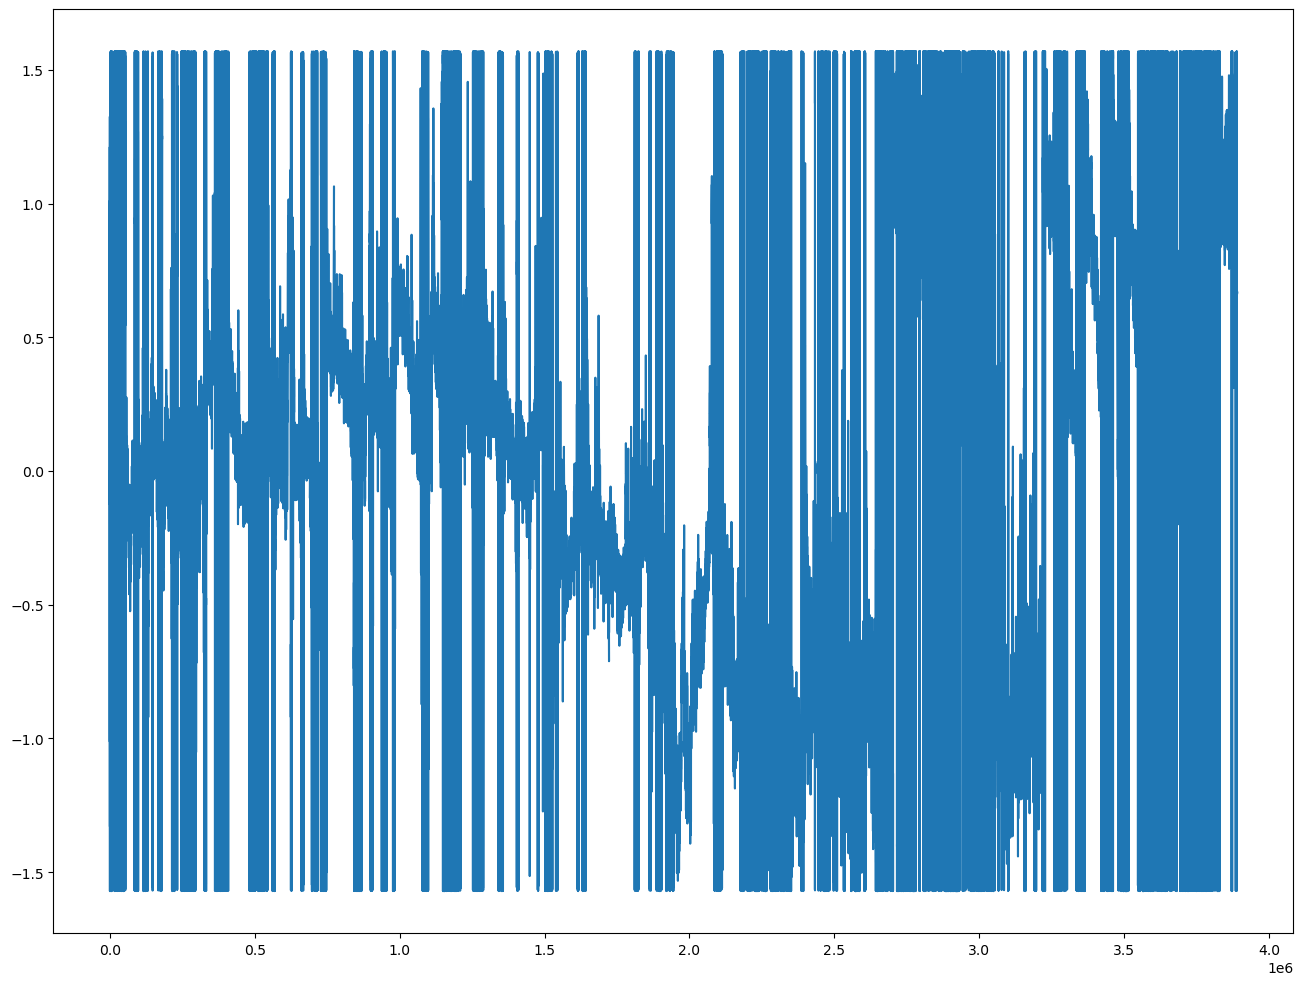

In [360]:
plt.plot(theta_interp[0])

In [234]:
def find_large_trends(time_series, window_size = 50):
    slopes = []

    for i in range(len(time_series) - window_size):
        window = time_series[i:i+window_size]
        x = np.linspace(1,window_size,window_size)
        x = x.reshape(-1,1)
        model = LinearRegression()
        model.fit(x, time_series[i:i+window_size])
        slopes.append(model.coef_[0])
    return slopes

@njit
def intervals(time_series_slopes, threshold = 1):
    indices = []
    i = 0
    while i < len(time_series_slopes) :
        k = 0
        while time_series_slopes[i+k] > threshold :
            k +=1
        if k >= 200 :
            indices.append((i,i+k))
        i = i+k+1
    return np.array(indices)

def find_major_increasing_trends(signal):
    slopes = find_large_trends(signal, window_size = 50)
    durations_interv = intervals(slopes, threshold = 1)
    return durations_interv

In [262]:
extents = find_major_increasing_trends(all_alti)

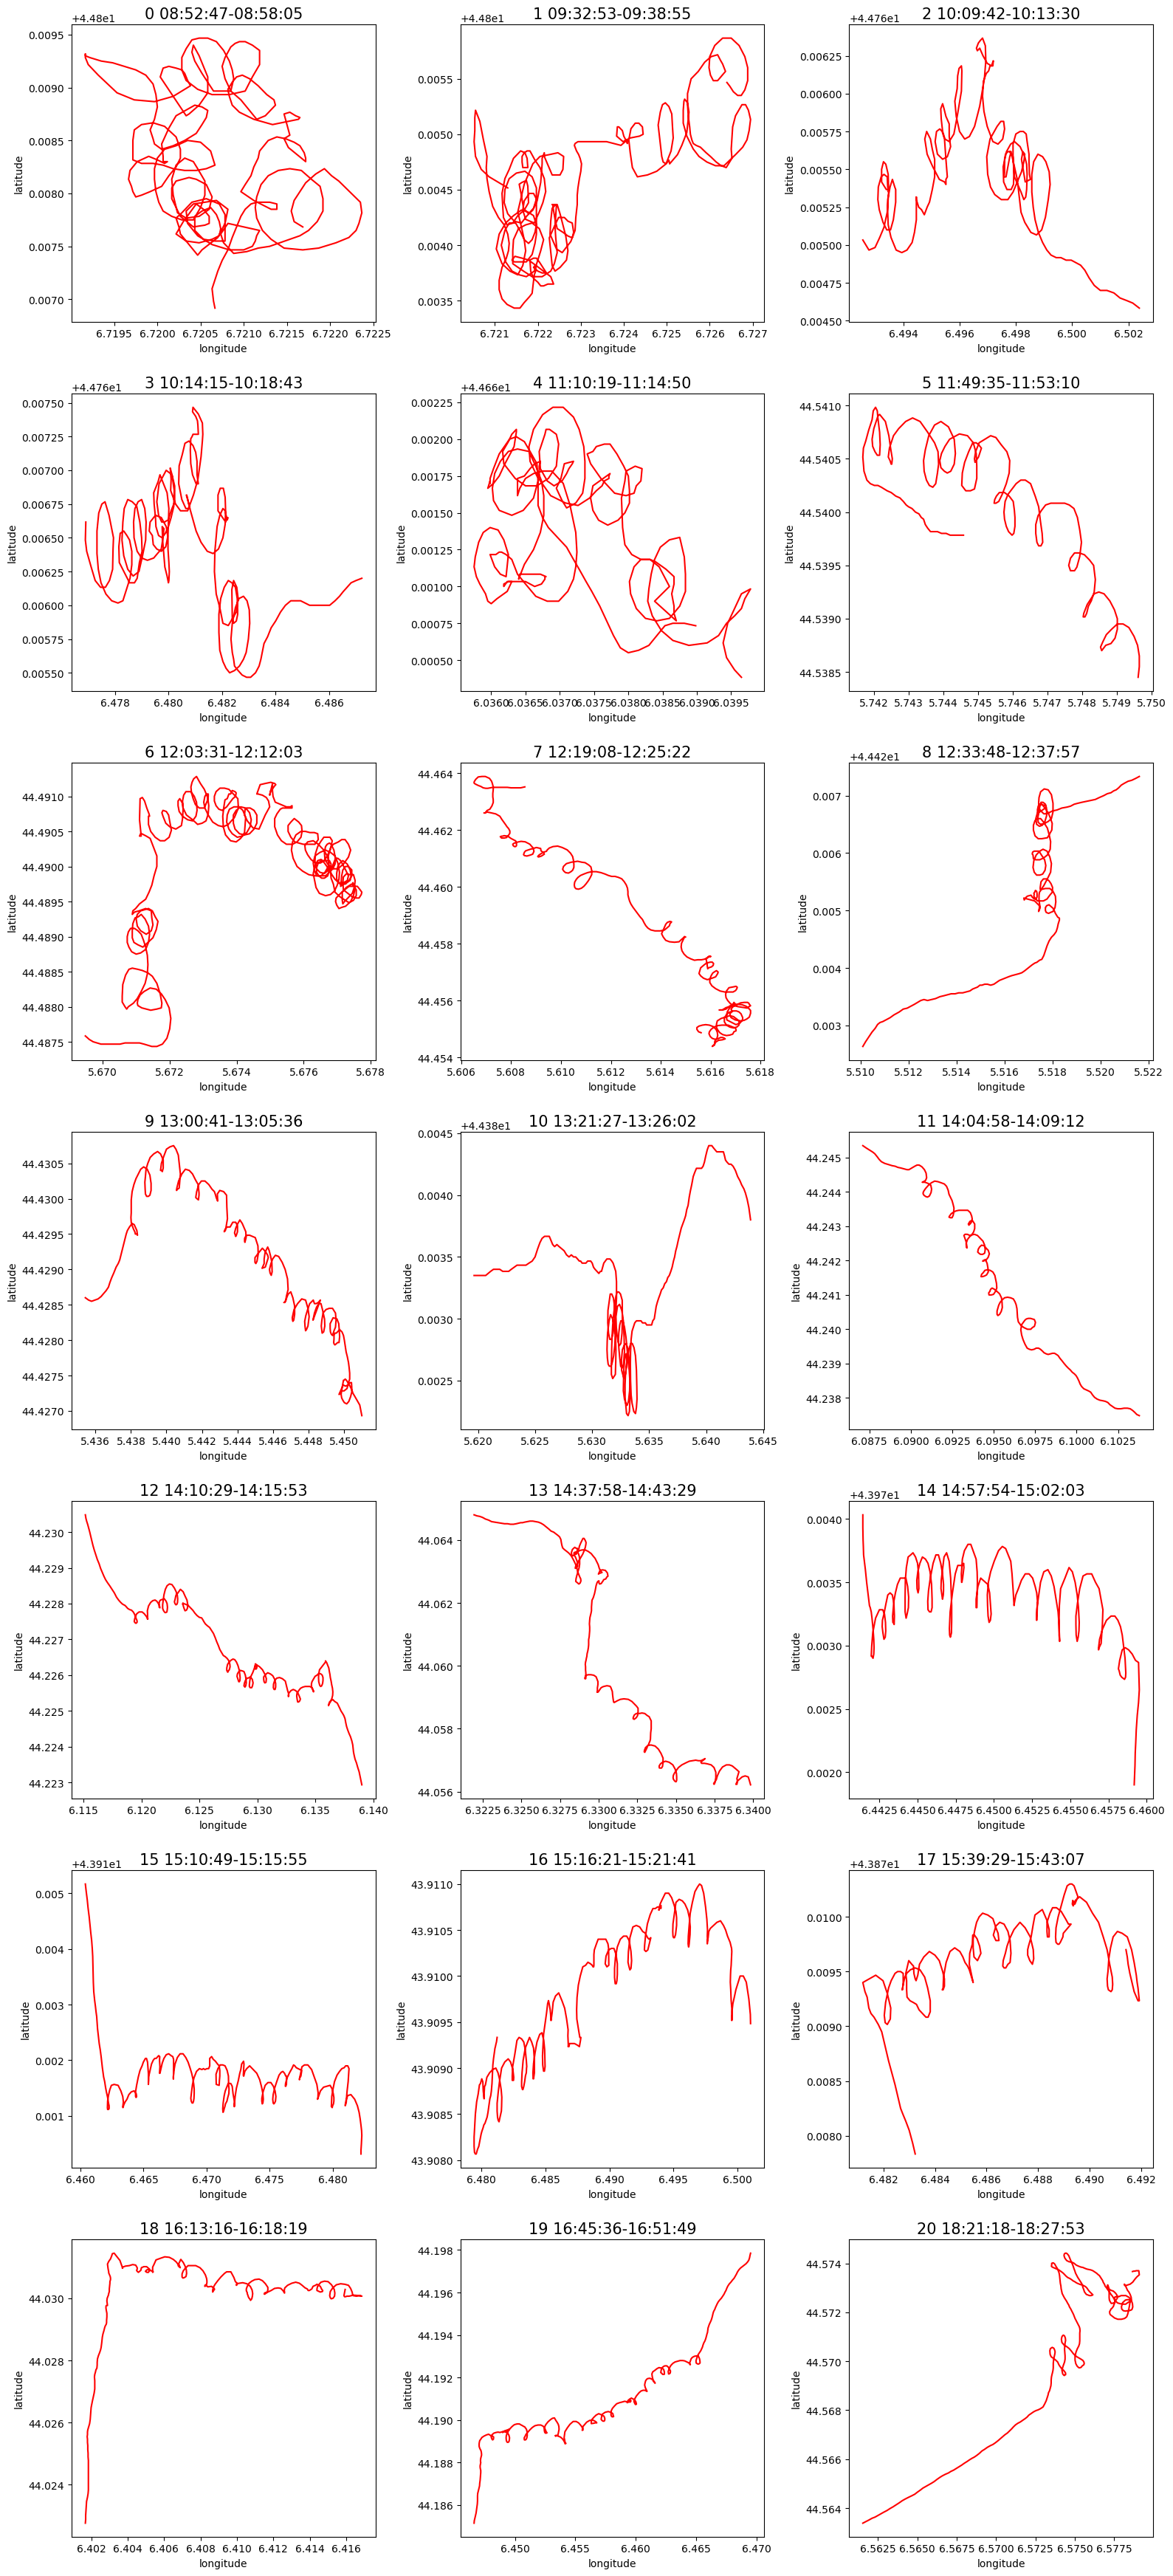

In [313]:
fig, axs = plt.subplots(7, 3, figsize=(16, 35))

for i in range(21):
    ax = axs[i//3,i%3]
    ext = extents[i]
    ax.plot(all_lon[ext[0]:ext[1]], all_lat[ext[0]:ext[1]], 'r-')
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.set_title(str(i) + ' ' + str(all_time[extents[i,0]]) + '-' +str(all_time[extents[i,1]]),fontsize=15)

plt.tight_layout()
plt.show()

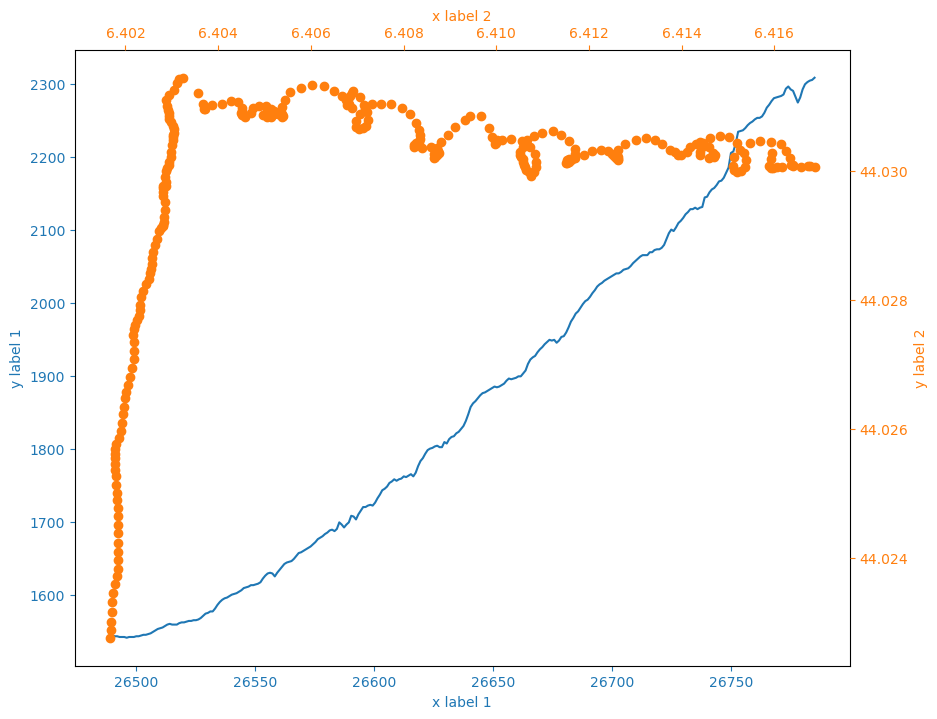

In [340]:
import matplotlib.pyplot as plt

ext = extents[18]

t = np.linspace(ext[0],ext[1],ext[1]-ext[0])
x_values1=t
y_values1=all_alti[ext[0]:ext[1]]

x_values2=all_lon[ext[0]:ext[1]]
y_values2=all_lat[ext[0]:ext[1]]

fig=plt.figure(figsize = (10,8))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.plot(x_values1, y_values1, color="C0")
ax.set_xlabel("x label 1", color="C0")
ax.set_ylabel("y label 1", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2.scatter(x_values2, y_values2, color="C1")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('x label 2', color="C1") 
ax2.set_ylabel('y label 2', color="C1")       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")

plt.show()

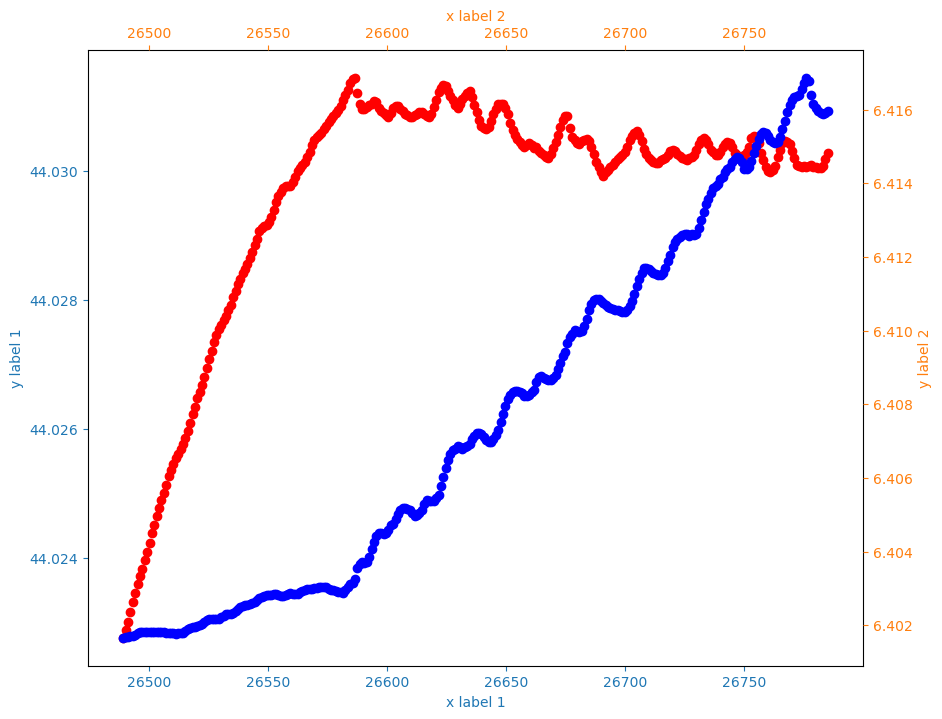

In [355]:
import matplotlib.pyplot as plt

ext = extents[18]

t = np.linspace(ext[0],ext[1],ext[1]-ext[0])
x_values1=t
y_values1=all_lat[ext[0]:ext[1]]

x_values2=t
y_values2=all_lon[ext[0]:ext[1]]

fig=plt.figure(figsize = (10,8))
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)

ax.plot(x_values1, y_values1, 'ro')
ax.set_xlabel("x label 1", color="C0")
ax.set_ylabel("y label 1", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2.plot(x_values2, y_values2, 'bo')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('x label 2', color="C1") 
ax2.set_ylabel('y label 2', color="C1")       
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="C1")
ax2.tick_params(axis='y', colors="C1")

plt.show()

In [370]:
from scipy.interpolate import BSpline, make_interp_spline

In [372]:
ext = extents[18]
t = np.linspace(ext[0],ext[1],ext[1]-ext[0])
t_new = np.linspace(ext[0],ext[1],len(t)*100)
spl = make_interp_spline(t, np.c_[all_lon[ext[0]:ext[1]], all_lat[ext[0]:ext[1]]])
lon_new, lat_new = spl(t_new).T

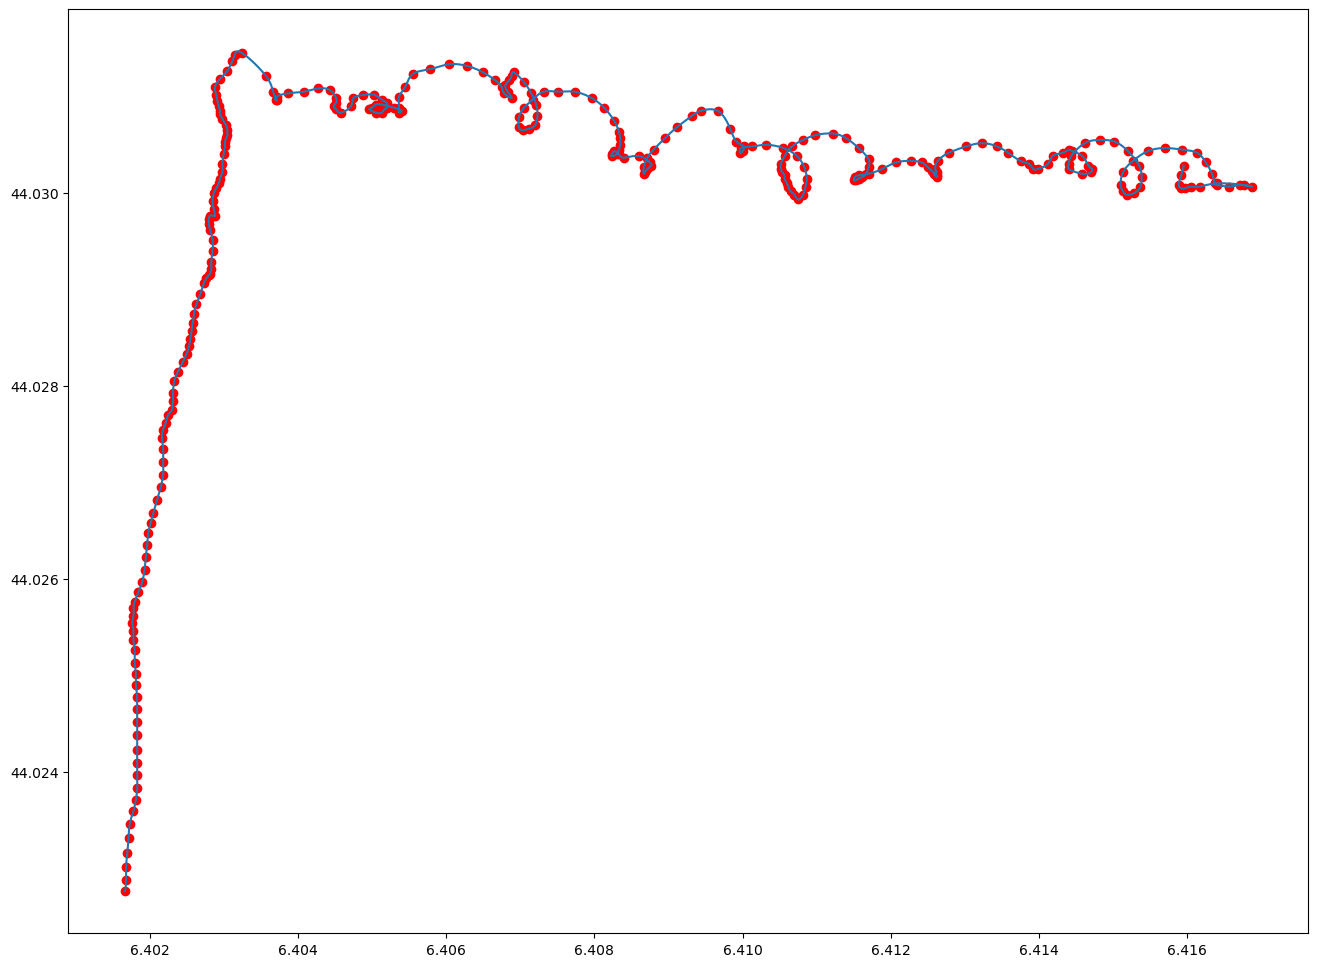

In [374]:
plt.plot(all_lon[ext[0]:ext[1]], all_lat[ext[0]:ext[1]], 'ro')

plt.plot(lon_new, lat_new, '-')

plt.show()

In [375]:
n = len(lon_new)
theta_new = np.zeros((1,n-1))
for j in range(n-1):
        theta_new[0,j] = np.arctan((lat_new[j+1]-lat_new[j])/(lon_new[j+1]-lon_new[j]))

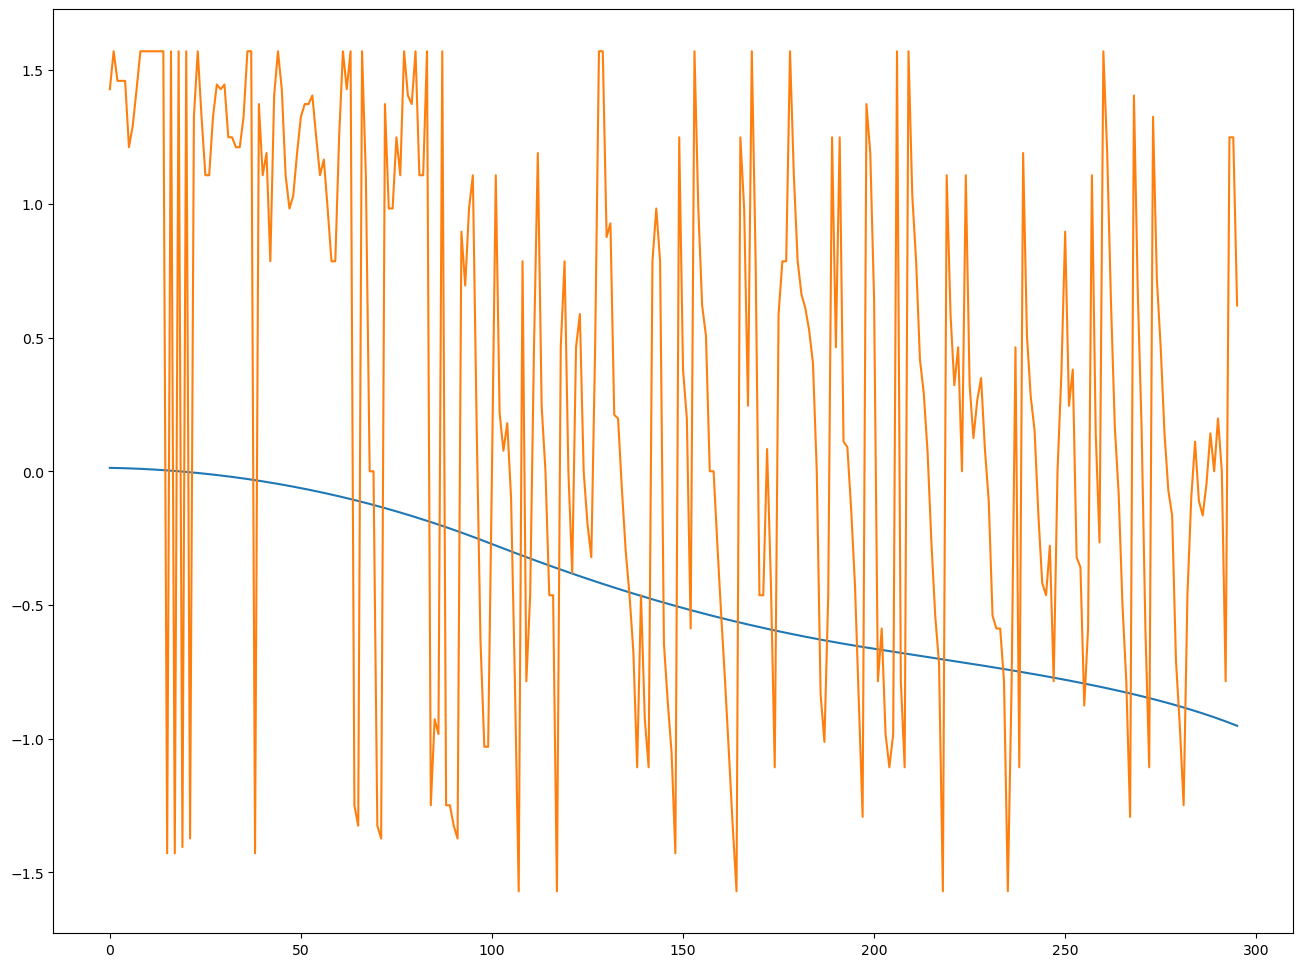

In [379]:
plt.plot(theta_new[0,ext[0]:ext[1]])
plt.plot(theta[0,ext[0]:ext[1]])